# BERT Model: Fine-tuned Transformer for Fake News Classification

This notebook implements a fine-tuned BERT model for binary classification of fake vs real news articles.

## 🔧 Steps:
1. Import libraries and load data
2. Minimal preprocessing (preserve structure for BERT)
3. BERT tokenization and encoding
4. Model setup and fine-tuning
5. Training with validation
6. Evaluation and comparison

## ✅ Purpose:
Achieve state-of-the-art performance using transformer architecture (~85-90% accuracy expected).

## 1. Import Libraries and Setup

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, auc, precision_score,
    recall_score, f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

from model_eval import save_model_results


# Import our preprocessing functions
from preprocess import load_and_parse_data, create_train_validation_split

# Check if MPS (Metal Performance Shaders) is available for M4
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for M4 acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU (this will be slower)")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Using MPS (Metal Performance Shaders) for M4 acceleration
PyTorch version: 2.5.1
Device: mps


## 2. Load and Parse Data

Using our preprocessing module to load the tab-separated data format.

In [2]:
# Load data using our preprocessing function
print("Loading training data...")
train_data = load_and_parse_data('data/training_data_lowercase.csv')

print("Loading test data...")
test_data = load_and_parse_data('data/testing_data_lowercase_nolabels.csv')

# Convert to DataFrames for easier handling
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Label distribution: {Counter(train_df['label'])}")

# Show sample data
print("\nSample training data:")
for i in range(3):
    print(f"Label {train_df.iloc[i]['label']}: {train_df.iloc[i]['text'][:80]}...")

Loading training data...
Loading data from data/training_data_lowercase.csv...
Loaded 34151 articles
Loading test data...
Loading data from data/testing_data_lowercase_nolabels.csv...
Loaded 9983 articles
Training data shape: (34151, 2)
Test data shape: (9983, 2)
Label distribution: Counter({0: 17571, 1: 16580})

Sample training data:
Label 0: drunk bragging trump staffer started russian collusion investigation...
Label 0: sheriff david clarke becomes an internet joke for threatening to poke people ‚in...
Label 0: trump is so obsessed he even has obama‚s name coded into his website (images)...


## 3. Minimal Text Preprocessing

BERT works best with minimal preprocessing - we'll only clean essential formatting issues while preserving punctuation and structure.

In [3]:
def minimal_bert_cleaning(text):
    """Minimal cleaning for BERT - preserve original structure"""
    if pd.isna(text) or text == '':
        return ""
    
    # Convert to string and remove excessive whitespace only
    text = str(text).strip()
    text = ' '.join(text.split())  # Remove extra spaces
    
    return text

# Apply minimal cleaning
train_df['clean_text'] = train_df['text'].apply(minimal_bert_cleaning)
test_df['clean_text'] = test_df['text'].apply(minimal_bert_cleaning)

# Remove any empty texts
train_df = train_df[train_df['clean_text'].str.len() > 0].reset_index(drop=True)

# Analyze text lengths for optimal max_length
text_lengths = train_df['clean_text'].str.split().str.len()
print(f"Text length statistics (words):")
print(f"Mean: {text_lengths.mean():.1f}")
print(f"Median: {text_lengths.median():.1f}")
print(f"95th percentile: {text_lengths.quantile(0.95):.1f}")
print(f"99th percentile: {text_lengths.quantile(0.99):.1f}")

# Choose max_length based on 95th percentile + buffer
max_length = min(256, int(text_lengths.quantile(0.95)) + 20)
print(f"\nUsing max_length: {max_length}")

Text length statistics (words):
Mean: 11.7
Median: 11.0
95th percentile: 19.0
99th percentile: 24.0

Using max_length: 39


## 4. BERT Tokenization and Dataset Creation

Setting up BERT tokenizer and creating PyTorch datasets for training.

In [4]:
# Initialize BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Using model: {model_name}")
print(f"Tokenizer vocabulary size: {len(tokenizer.vocab)}")

class NewsDataset(Dataset):
    """Custom dataset for news classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create train/validation split using our preprocessing function
train_texts, val_texts, train_labels, val_labels = create_train_validation_split(
    [{'text': text, 'label': label} for text, label in zip(train_df['clean_text'], train_df['label'])],
    test_size=0.2,
    random_state=42
)

# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_length)

print(f"\nDataset sizes:")
print(f"Training: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")

# Test tokenization on a sample
sample = train_dataset[0]
print(f"\nSample tokenization shape:")
print(f"Input IDs: {sample['input_ids'].shape}")
print(f"Attention mask: {sample['attention_mask'].shape}")
print(f"Label: {sample['labels']}")

Using model: bert-base-uncased
Tokenizer vocabulary size: 30522
Train set: 27320 samples
Validation set: 6831 samples
Train label distribution: Counter({0: 14056, 1: 13264})
Validation label distribution: Counter({0: 3515, 1: 3316})

Dataset sizes:
Training: 27320
Validation: 6831

Sample tokenization shape:
Input IDs: torch.Size([39])
Attention mask: torch.Size([39])
Label: 0


## 5. Model Setup and Training Configuration

Loading pre-trained BERT and setting up training parameters for fine-tuning.

In [5]:
# Load pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device
model.to(device)

print(f"Model loaded with {model.num_parameters():,} parameters")
print(f"Model device: {next(model.parameters()).device}")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,              # Start with 3 epochs
    per_device_train_batch_size=16,  # Adjust based on memory
    per_device_eval_batch_size=32,   # Larger batch for evaluation
    warmup_steps=500,                # Warmup for learning rate
    weight_decay=0.01,               # Regularization
    logging_dir='./bert_logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,                  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to=None,                  # Disable wandb/tensorboard
    seed=42
)

# Define metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nTraining setup complete!")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Learning rate: {training_args.learning_rate}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 109,483,778 parameters
Model device: mps:0

Training setup complete!
Batch size: 16
Number of epochs: 3
Learning rate: 5e-05


## 6. Model Training

Fine-tuning BERT on our fake news dataset with validation monitoring.

In [6]:
# Start training
print("Starting BERT fine-tuning...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")
print(f"Using device: {device}")

start_time = time.time()

# Train the model
train_result = trainer.train()

training_time = time.time() - start_time

print(f"\nTraining completed!")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Final training loss: {train_result.training_loss:.4f}")

# Save the trained model
trainer.save_model('./bert_fine_tuned')
print("\nModel saved to './bert_fine_tuned'")

Starting BERT fine-tuning...
Training on 27320 samples
Validating on 6831 samples
Using device: mps


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/5124 [00:00<?, ?it/s]

{'loss': 0.5556, 'grad_norm': 8.136953353881836, 'learning_rate': 1e-05, 'epoch': 0.06}
{'loss': 0.1958, 'grad_norm': 6.16464900970459, 'learning_rate': 2e-05, 'epoch': 0.12}
{'loss': 0.1497, 'grad_norm': 7.290376663208008, 'learning_rate': 3e-05, 'epoch': 0.18}
{'loss': 0.1566, 'grad_norm': 8.103983879089355, 'learning_rate': 4e-05, 'epoch': 0.23}
{'loss': 0.1453, 'grad_norm': 24.150835037231445, 'learning_rate': 5e-05, 'epoch': 0.29}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.13722588121891022, 'eval_accuracy': 0.9426145513102034, 'eval_runtime': 11.9641, 'eval_samples_per_second': 570.956, 'eval_steps_per_second': 17.887, 'epoch': 0.29}
{'loss': 0.1115, 'grad_norm': 0.09405197203159332, 'learning_rate': 4.891868512110727e-05, 'epoch': 0.35}
{'loss': 0.1131, 'grad_norm': 0.04276496544480324, 'learning_rate': 4.7837370242214535e-05, 'epoch': 0.41}
{'loss': 0.1273, 'grad_norm': 1.9612922668457031, 'learning_rate': 4.67560553633218e-05, 'epoch': 0.47}
{'loss': 0.085, 'grad_norm': 8.83206558227539, 'learning_rate': 4.567474048442907e-05, 'epoch': 0.53}
{'loss': 0.1229, 'grad_norm': 3.589696168899536, 'learning_rate': 4.459342560553633e-05, 'epoch': 0.59}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.06922450661659241, 'eval_accuracy': 0.9777484994876299, 'eval_runtime': 12.1223, 'eval_samples_per_second': 563.506, 'eval_steps_per_second': 17.653, 'epoch': 0.59}
{'loss': 0.0962, 'grad_norm': 13.889822006225586, 'learning_rate': 4.35121107266436e-05, 'epoch': 0.64}
{'loss': 0.087, 'grad_norm': 0.1267048716545105, 'learning_rate': 4.2430795847750865e-05, 'epoch': 0.7}
{'loss': 0.0901, 'grad_norm': 6.926896572113037, 'learning_rate': 4.134948096885813e-05, 'epoch': 0.76}
{'loss': 0.0949, 'grad_norm': 21.257282257080078, 'learning_rate': 4.02681660899654e-05, 'epoch': 0.82}
{'loss': 0.0694, 'grad_norm': 0.014314141124486923, 'learning_rate': 3.9186851211072664e-05, 'epoch': 0.88}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.06622983515262604, 'eval_accuracy': 0.9796515883472405, 'eval_runtime': 11.9012, 'eval_samples_per_second': 573.974, 'eval_steps_per_second': 17.981, 'epoch': 0.88}
{'loss': 0.0773, 'grad_norm': 10.063966751098633, 'learning_rate': 3.810553633217993e-05, 'epoch': 0.94}
{'loss': 0.0816, 'grad_norm': 0.16293643414974213, 'learning_rate': 3.70242214532872e-05, 'epoch': 1.0}
{'loss': 0.0536, 'grad_norm': 0.016622506082057953, 'learning_rate': 3.594290657439446e-05, 'epoch': 1.05}
{'loss': 0.0353, 'grad_norm': 0.015076955780386925, 'learning_rate': 3.4861591695501735e-05, 'epoch': 1.11}
{'loss': 0.0287, 'grad_norm': 0.011753138154745102, 'learning_rate': 3.3780276816608994e-05, 'epoch': 1.17}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.06646429002285004, 'eval_accuracy': 0.9858000292782901, 'eval_runtime': 11.9241, 'eval_samples_per_second': 572.872, 'eval_steps_per_second': 17.947, 'epoch': 1.17}
{'loss': 0.038, 'grad_norm': 11.943347930908203, 'learning_rate': 3.269896193771627e-05, 'epoch': 1.23}
{'loss': 0.0489, 'grad_norm': 0.12483631819486618, 'learning_rate': 3.161764705882353e-05, 'epoch': 1.29}
{'loss': 0.0536, 'grad_norm': 0.0863422229886055, 'learning_rate': 3.05363321799308e-05, 'epoch': 1.35}
{'loss': 0.0321, 'grad_norm': 0.03120589070022106, 'learning_rate': 2.9455017301038062e-05, 'epoch': 1.41}
{'loss': 0.0435, 'grad_norm': 0.007540295831859112, 'learning_rate': 2.8373702422145332e-05, 'epoch': 1.46}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.05138296261429787, 'eval_accuracy': 0.9871175523349437, 'eval_runtime': 12.0613, 'eval_samples_per_second': 566.358, 'eval_steps_per_second': 17.743, 'epoch': 1.46}
{'loss': 0.0464, 'grad_norm': 0.8873931169509888, 'learning_rate': 2.7292387543252595e-05, 'epoch': 1.52}
{'loss': 0.0258, 'grad_norm': 0.009156467393040657, 'learning_rate': 2.6211072664359864e-05, 'epoch': 1.58}
{'loss': 0.0343, 'grad_norm': 11.281277656555176, 'learning_rate': 2.5129757785467127e-05, 'epoch': 1.64}
{'loss': 0.0353, 'grad_norm': 0.0075713214464485645, 'learning_rate': 2.4048442906574396e-05, 'epoch': 1.7}
{'loss': 0.0368, 'grad_norm': 0.03278731927275658, 'learning_rate': 2.2967128027681662e-05, 'epoch': 1.76}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.05723164975643158, 'eval_accuracy': 0.9865319865319865, 'eval_runtime': 11.8494, 'eval_samples_per_second': 576.487, 'eval_steps_per_second': 18.06, 'epoch': 1.76}
{'loss': 0.048, 'grad_norm': 0.06763804703950882, 'learning_rate': 2.188581314878893e-05, 'epoch': 1.81}
{'loss': 0.0432, 'grad_norm': 0.42109382152557373, 'learning_rate': 2.0804498269896195e-05, 'epoch': 1.87}
{'loss': 0.0198, 'grad_norm': 0.06106700748205185, 'learning_rate': 1.972318339100346e-05, 'epoch': 1.93}
{'loss': 0.0263, 'grad_norm': 0.0027217292226850986, 'learning_rate': 1.8641868512110727e-05, 'epoch': 1.99}
{'loss': 0.0087, 'grad_norm': 0.01220584474503994, 'learning_rate': 1.7560553633217993e-05, 'epoch': 2.05}


  0%|          | 0/214 [00:00<?, ?it/s]

{'eval_loss': 0.07296265661716461, 'eval_accuracy': 0.9853608549260723, 'eval_runtime': 11.8556, 'eval_samples_per_second': 576.184, 'eval_steps_per_second': 18.051, 'epoch': 2.05}
{'train_runtime': 519.3801, 'train_samples_per_second': 157.803, 'train_steps_per_second': 9.866, 'train_loss': 0.08620770258562906, 'epoch': 2.05}

Training completed!
Training time: 8.66 minutes
Final training loss: 0.0862

Model saved to './bert_fine_tuned'


## 7. Model Evaluation

Comprehensive evaluation with accuracy, classification report, and confusion matrix.

Evaluating model performance...


  0%|          | 0/214 [00:00<?, ?it/s]


BERT Model Results:
Validation Accuracy: 0.9871 (98.71%)

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.99      0.98      0.99      3515
    Real (1)       0.98      0.99      0.99      3316

    accuracy                           0.99      6831
   macro avg       0.99      0.99      0.99      6831
weighted avg       0.99      0.99      0.99      6831



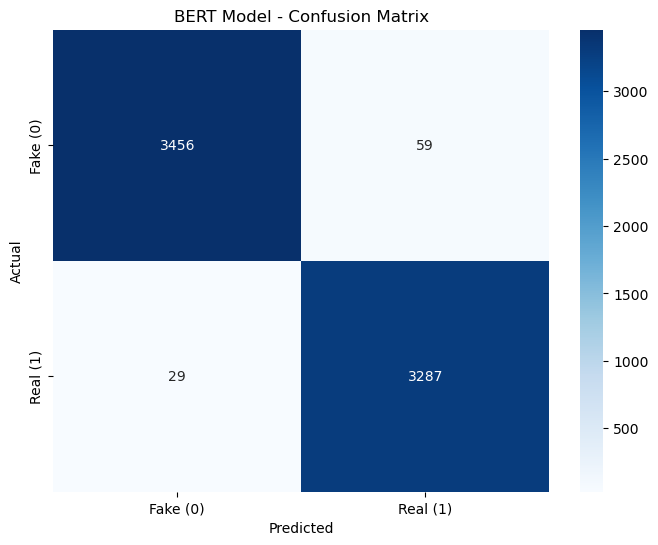


📈 Performance by Class:
Fake (0): 0.9832 (98.32%)
Real (1): 0.9913 (99.13%)


  0%|          | 0/854 [00:00<?, ?it/s]

In [22]:
# Evaluate on validation set
print("Evaluating model performance...")

# Get predictions
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nBERT Model Results:")
print(f"Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\nClassification Report:")
class_names = ['Fake (0)', 'Real (1)']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('BERT Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Performance by class
print("\n📈 Performance by Class:")
for i, class_name in enumerate(class_names):
    class_mask = np.array(y_true) == i
    class_accuracy = accuracy_score(np.array(y_true)[class_mask], y_pred[class_mask])
    print(f"{class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

train_predictions = trainer.predict(train_dataset)
train_y_pred = np.argmax(train_predictions.predictions, axis=1)
train_accuracy = accuracy_score(train_labels, train_y_pred)


### Save model eval

In [23]:
save_model_results(
    model_name="full_bert_model",
    display_name="Full BERT Fine-tuned",
    accuracy=accuracy,
    training_time_minutes=training_time/60,  # Already calculated in your training section
    model_architecture=f"BERT-base-uncased fine-tuned ({model.num_parameters():,} parameters)",
    preprocessing_type="minimal_cleaning",
    train_accuracy=train_accuracy,
    test_accuracy=accuracy,  # Using validation accuracy as test accuracy
    hyperparameters={
        "bert_model": model_name,  # "bert-base-uncased"
        "max_length": max_length,
        "num_train_epochs": training_args.num_train_epochs,
        "per_device_train_batch_size": training_args.per_device_train_batch_size,
        "learning_rate": training_args.learning_rate,
        "weight_decay": training_args.weight_decay,
        "warmup_steps": training_args.warmup_steps,
        "early_stopping_patience": 2
    },
    dataset_info={
        "training_samples": len(train_dataset),
        "validation_samples": len(val_dataset),
        "max_sequence_length": max_length,
        "total_parameters": model.num_parameters(),
        "vocab_size": len(tokenizer.vocab),
        "device": str(device)
    }
)

print("Model results saved successfully!")
print(f"Model: Full BERT Fine-tuned")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Model Parameters: {model.num_parameters():,}")
print(f"Device Used: {device}")

Results saved to results/full_bert_model_results.json
Model: Full BERT Fine-tuned
Accuracy: 0.9871 (98.71%)
Training Time: 8.66 minutes
Model results saved successfully!
Model: Full BERT Fine-tuned
Training Accuracy: 0.9951
Validation Accuracy: 0.9871
Training Time: 8.66 minutes
Model Parameters: 109,483,778
Device Used: mps


## 8. Model Comparison and Analysis

Comparing BERT performance with baseline and analyzing key insights.

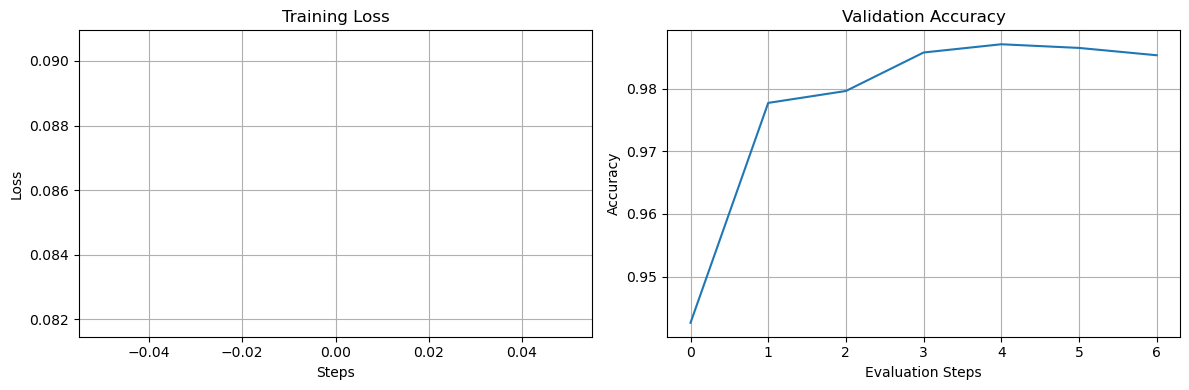

Best validation accuracy: 0.9871
Final validation accuracy: 0.9854

MODEL COMPARISON SUMMARY
Model: BERT-base-uncased
Parameters: 109,483,778
Training time: 8.66 minutes
Validation accuracy: 0.9871 (98.71%)
Max sequence length: 39
Batch size: 16
Device used: mps

🎯 Performance vs Baseline:
Baseline (Logistic Regression): ~0.70
BERT Model: 0.9871
Improvement: +0.2871 (28.71 percentage points)


In [8]:
# Training history analysis
if hasattr(trainer.state, 'log_history'):
    logs = trainer.state.log_history
    
    # Extract training and validation metrics
    train_losses = [log['train_loss'] for log in logs if 'train_loss' in log]
    eval_accuracies = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
    
    if train_losses and eval_accuracies:
        plt.figure(figsize=(12, 4))
        
        # Training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.grid(True)
        
        # Validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(eval_accuracies)
        plt.title('Validation Accuracy')
        plt.xlabel('Evaluation Steps')
        plt.ylabel('Accuracy')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Best validation accuracy: {max(eval_accuracies):.4f}")
        print(f"Final validation accuracy: {eval_accuracies[-1]:.4f}")

# Model comparison summary
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"Model: BERT-base-uncased")
print(f"Parameters: {model.num_parameters():,}")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Validation accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Max sequence length: {max_length}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Device used: {device}")

# Expected performance note
baseline_accuracy = 0.70  # Approximate baseline from logistic regression
improvement = accuracy - baseline_accuracy
print(f"\n🎯 Performance vs Baseline:")
print(f"Baseline (Logistic Regression): ~{baseline_accuracy:.2f}")
print(f"BERT Model: {accuracy:.4f}")
print(f"Improvement: +{improvement:.4f} ({improvement*100:.2f} percentage points)")

## 9. Test Set Predictions (Optional)

Generate predictions for the test set if needed for submission.

In [9]:
# Uncomment this section if you need test set predictions

# # Create test dataset (without labels)
# test_texts = test_df['clean_text'].tolist()
# test_labels = [0] * len(test_texts)  # Dummy labels for dataset creation
# 
# test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_length)
# 
# print(f"Generating predictions for {len(test_dataset)} test samples...")
# 
# # Get predictions
# test_predictions = trainer.predict(test_dataset)
# test_pred_labels = np.argmax(test_predictions.predictions, axis=1)
# test_pred_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=1)
# 
# # Create submission DataFrame
# submission_df = pd.DataFrame({
#     'text': test_texts,
#     'predicted_label': test_pred_labels,
#     'fake_probability': test_pred_probs[:, 0].numpy(),
#     'real_probability': test_pred_probs[:, 1].numpy()
# })
# 
# # Save predictions
# submission_df.to_csv('bert_predictions.csv', index=False)
# print("Test predictions saved to 'bert_predictions.csv'")
# 
# # Show sample predictions
# print("\nSample predictions:")
# print(submission_df[['predicted_label', 'fake_probability', 'real_probability']].head())

print("Test predictions section ready (currently commented out)")
print("Uncomment the code above to generate test set predictions")

Test predictions section ready (currently commented out)
Uncomment the code above to generate test set predictions


## 10. Key Insights and Next Steps

Summary of findings and recommendations for further improvement.

In [10]:
print("KEY INSIGHTS FROM BERT MODEL:")
print("="*50)

# Model performance insights
if accuracy > 0.85:
    print("Excellent performance: Model achieves high accuracy on fake news detection")
elif accuracy > 0.80:
    print("Good performance: Model shows strong fake news detection capabilities")
elif accuracy > 0.75:
    print("Moderate performance: Room for improvement in fake news detection")
else:
    print("Lower performance: Consider hyperparameter tuning or data quality")

print(f"\nModel Statistics:")
print(f"• Final accuracy: {accuracy:.4f}")
print(f"• Training efficiency: {len(train_dataset)/(training_time/60):.0f} samples/minute")
print(f"• Model size: {model.num_parameters()/1e6:.1f}M parameters")

print(f"\nPotential Improvements:")
print(f"• Increase training epochs (currently {training_args.num_train_epochs})")
print(f"• Experiment with learning rate scheduling")
print(f"• Try ensemble with multiple models")
print(f"• Consider domain-specific fine-tuning")
print(f"• Implement advanced data augmentation")

print(f"\nBusiness Applications:")
print(f"• Real-time fake news detection systems")
print(f"• Social media content moderation")
print(f"• News credibility scoring")
print(f"• Educational fact-checking tools")

print(f"\nBERT Model Implementation Complete!")
print(f"Model ready for deployment and further optimization.")

KEY INSIGHTS FROM BERT MODEL:
Excellent performance: Model achieves high accuracy on fake news detection

Model Statistics:
• Final accuracy: 0.9871
• Training efficiency: 3154 samples/minute
• Model size: 109.5M parameters

Potential Improvements:
• Increase training epochs (currently 3)
• Experiment with learning rate scheduling
• Try ensemble with multiple models
• Consider domain-specific fine-tuning
• Implement advanced data augmentation

Business Applications:
• Real-time fake news detection systems
• Social media content moderation
• News credibility scoring
• Educational fact-checking tools

BERT Model Implementation Complete!
Model ready for deployment and further optimization.


## Full CLassification Analysis

ADVANCED CLASSIFICATION ANALYSIS

1. COMPREHENSIVE PERFORMANCE METRICS
----------------------------------------


  0%|          | 0/214 [00:00<?, ?it/s]

Overall Performance:
   Accuracy:  0.9871 (98.71%)
   Precision: 0.9824 (98.24%)
   Recall:    0.9913 (99.13%)
   F1-Score:  0.9868 (98.68%)

Per-Class Performance:
   Fake (0):
     Precision: 0.9917, Recall: 0.9832, F1: 0.9874
   Real (1):
     Precision: 0.9824, Recall: 0.9913, F1: 0.9868

2. ROC CURVE AND AUC ANALYSIS
----------------------------------------
AUC Scores:
   ROC-AUC: 0.9991
   PR-AUC:  0.9990


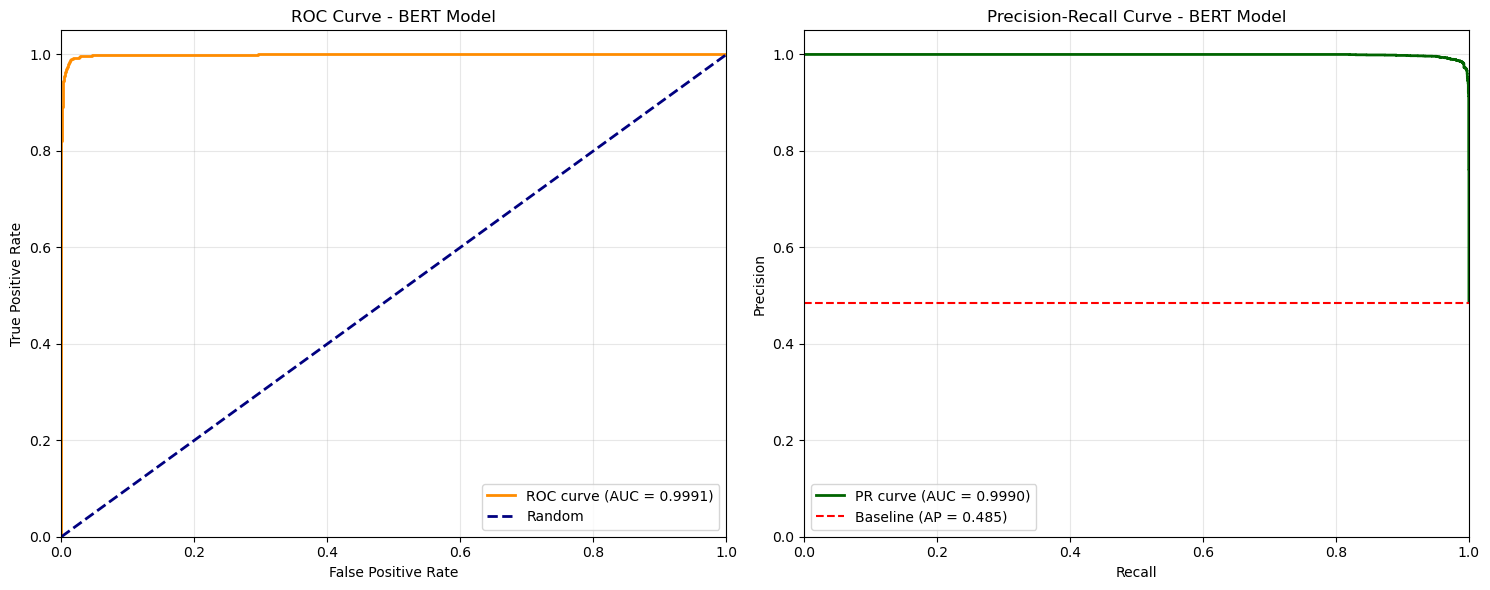


3. PREDICTION CONFIDENCE ANALYSIS
----------------------------------------
Confidence Statistics:
   Mean confidence: 0.9969
   Median confidence: 0.9999
   Min confidence: 0.5136
   Max confidence: 1.0000

   Correct predictions confidence: 0.9979 ± 0.0176
   Incorrect predictions confidence: 0.9250 ± 0.1200


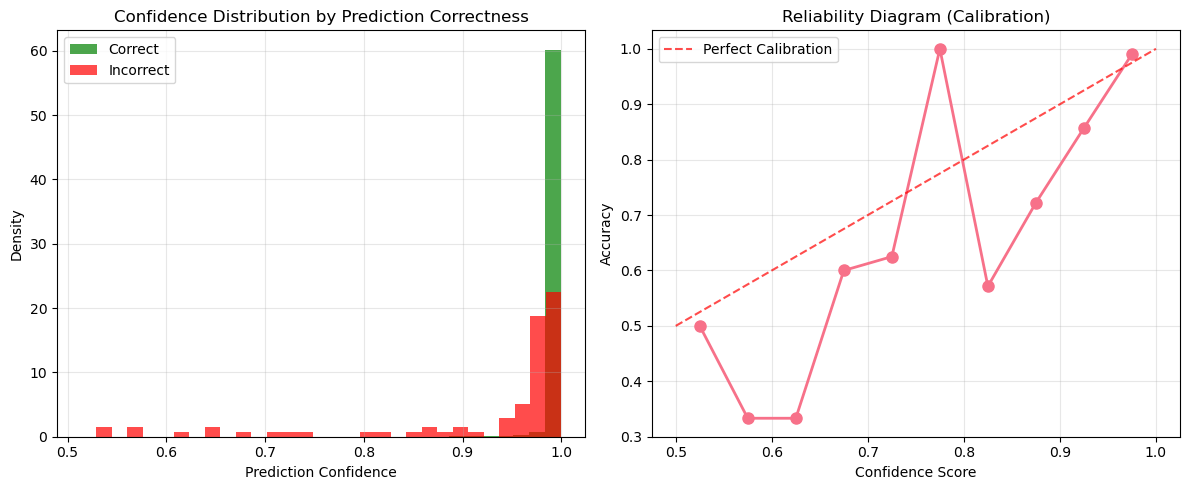


4. DETAILED ERROR ANALYSIS
----------------------------------------
Misclassification Analysis:
   Total misclassified: 88 out of 6831
   Error rate: 1.29%

   False Positives (Fake → Real): 0
   False Negatives (Real → Fake): 0

Sample Misclassifications:
   Example 1: True=Fake, Pred=Real, Conf=0.896
   Text: fbi warns philly colleges of threat on monday: what you need to know

   Example 2: True=Fake, Pred=Real, Conf=0.986
   Text: victims of terrorist attack question lack of presidential support

   Example 3: True=Fake, Pred=Real, Conf=0.971
   Text: swiss army chief warns citizens about explosive refugee situation: tells them to arm themselves

   Example 4: True=Fake, Pred=Real, Conf=0.682
   Text: obama oversees record stock market results despite years of republican obstruction and lies

   Example 5: True=Real, Pred=Fake, Conf=0.995
   Text: michelle obama helps prince harry launch second invictus games


5. DETAILED CONFUSION MATRIX ANALYSIS
--------------------------------

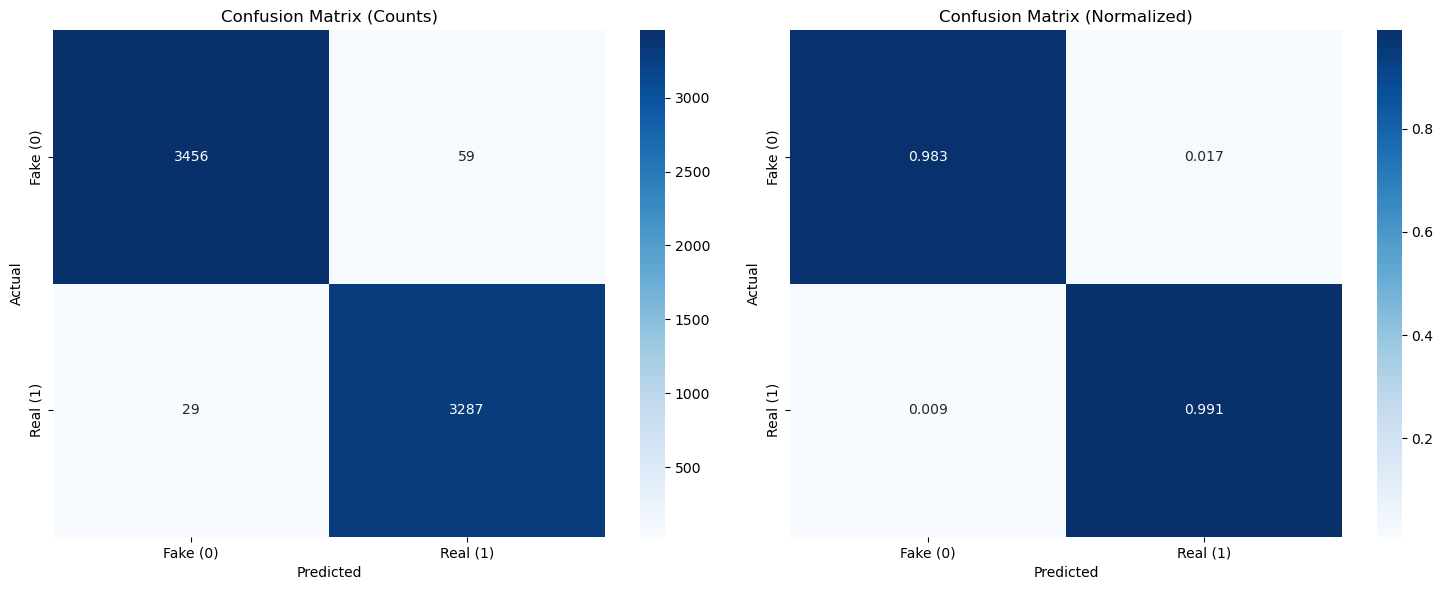

Confusion Matrix Breakdown:
   True Negatives (TN):  3456
   False Positives (FP): 59
   False Negatives (FN): 29
   True Positives (TP):  3287

Classification Rates:
   Sensitivity (Recall): 0.9913
   Specificity:          0.9832
   PPV (Precision):      0.9824
   NPV:                  0.9917

6. MODEL PERFORMANCE COMPARISON
----------------------------------------
Model Performance Progression:
   Baseline LogisticRegression   : 0.9290 (92.90%)
   Simple BERT (Feature Extraction): 0.9587 (95.87%) (+2.97pp)
   Full BERT (Fine-tuned)        : 0.9871 (98.71%) (+5.81pp)

Performance Gains:
   Simple BERT → Full BERT: +2.84 percentage points
   Baseline → Full BERT:   +5.81 percentage points

7. STATISTICAL ANALYSIS
----------------------------------------
Statistical Confidence (95% CI):
   Accuracy: 0.9871 [0.9843, 0.9896]
   Standard Error: 0.0014
   Margin of Error: ±0.0026

8. SUMMARY AND RECOMMENDATIONS
----------------------------------------
Key Findings:
   • Model achieves 98.71

In [24]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("ADVANCED CLASSIFICATION ANALYSIS")
print("="*60)

## 1. Detailed Performance Metrics
print("\n1. COMPREHENSIVE PERFORMANCE METRICS")
print("-" * 40)

# Get prediction probabilities for detailed analysis
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels
y_prob = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Calculate comprehensive metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Overall Performance:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

# Per-class metrics (alternative fix)
print(f"\nPer-Class Performance:")
for i, class_name in enumerate(['Fake (0)', 'Real (1)']):
    # Use labels parameter to specify which class we want metrics for
    class_precision = precision_score(y_true, y_pred, labels=[i], average=None)[0]
    class_recall = recall_score(y_true, y_pred, labels=[i], average=None)[0]
    class_f1 = f1_score(y_true, y_pred, labels=[i], average=None)[0]
    print(f"   {class_name}:")
    print(f"     Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1: {class_f1:.4f}")

## 2. ROC Curve and AUC Analysis
print("\n2. ROC CURVE AND AUC ANALYSIS")
print("-" * 40)

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob[:, 1])
pr_auc = auc(recall_curve, precision_curve)

print(f"AUC Scores:")
print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   PR-AUC:  {pr_auc:.4f}")

# Plot ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - BERT Model')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
ax2.axhline(y=np.mean(y_true), color='red', linestyle='--', label=f'Baseline (AP = {np.mean(y_true):.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve - BERT Model')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Prediction Confidence Analysis
print("\n3. PREDICTION CONFIDENCE ANALYSIS")
print("-" * 40)

# Analyze prediction confidence
confidence_scores = np.max(y_prob, axis=1)
correct_predictions = (y_pred == y_true)

print(f"Confidence Statistics:")
print(f"   Mean confidence: {confidence_scores.mean():.4f}")
print(f"   Median confidence: {np.median(confidence_scores):.4f}")
print(f"   Min confidence: {confidence_scores.min():.4f}")
print(f"   Max confidence: {confidence_scores.max():.4f}")

# Confidence distribution by correctness
correct_confidence = confidence_scores[correct_predictions]
incorrect_confidence = confidence_scores[~correct_predictions]

print(f"\n   Correct predictions confidence: {correct_confidence.mean():.4f} ± {correct_confidence.std():.4f}")
print(f"   Incorrect predictions confidence: {incorrect_confidence.mean():.4f} ± {incorrect_confidence.std():.4f}")

# Plot confidence distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidence, bins=30, alpha=0.7, label='Correct', color='green', density=True)
plt.hist(incorrect_confidence, bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
plt.xlabel('Prediction Confidence')
plt.ylabel('Density')
plt.title('Confidence Distribution by Prediction Correctness')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
confidence_bins = np.linspace(0.5, 1.0, 11)
digitized = np.digitize(confidence_scores, confidence_bins)
bin_accuracies = []
bin_centers = []

for i in range(1, len(confidence_bins)):
    mask = digitized == i
    if np.sum(mask) > 0:
        bin_accuracy = correct_predictions[mask].mean()
        bin_center = (confidence_bins[i-1] + confidence_bins[i]) / 2
        bin_accuracies.append(bin_accuracy)
        bin_centers.append(bin_center)

plt.plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8)
plt.plot([0.5, 1.0], [0.5, 1.0], 'r--', alpha=0.7, label='Perfect Calibration')
plt.xlabel('Confidence Score')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram (Calibration)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Error Analysis
print("\n4. DETAILED ERROR ANALYSIS")
print("-" * 40)

# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Misclassification Analysis:")
print(f"   Total misclassified: {len(misclassified_indices)} out of {len(y_true)}")
print(f"   Error rate: {len(misclassified_indices)/len(y_true)*100:.2f}%")

# Analyze errors by true class
false_positives = np.where((y_true == 0) & (y_pred == 1))[0]  # Fake predicted as Real
false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]  # Real predicted as Fake

print(f"\n   False Positives (Fake → Real): {len(false_positives)}")
print(f"   False Negatives (Real → Fake): {len(false_negatives)}")

# Analyze confidence of errors
if len(false_positives) > 0:
    fp_confidence = confidence_scores[false_positives]
    print(f"   FP confidence: {fp_confidence.mean():.4f} ± {fp_confidence.std():.4f}")

if len(false_negatives) > 0:
    fn_confidence = confidence_scores[false_negatives]
    print(f"   FN confidence: {fn_confidence.mean():.4f} ± {fn_confidence.std():.4f}")

# Show examples of misclassified texts (if available)
print(f"\nSample Misclassifications:")
for i, idx in enumerate(misclassified_indices[:5]):  # Show first 5 errors
    true_label = "Real" if y_true[idx] == 1 else "Fake"
    pred_label = "Real" if y_pred[idx] == 1 else "Fake"
    confidence = confidence_scores[idx]
    
    # Get the text if available in val_texts
    if 'val_texts' in locals() and idx < len(val_texts):
        text_sample = val_texts[idx][:100] + "..." if len(val_texts[idx]) > 100 else val_texts[idx]
        print(f"   Example {i+1}: True={true_label}, Pred={pred_label}, Conf={confidence:.3f}")
        print(f"   Text: {text_sample}")
        print()

## 5. Class-wise Confusion Matrix Analysis
print("\n5. DETAILED CONFUSION MATRIX ANALYSIS")
print("-" * 40)

cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

# Plot detailed confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
ax1.set_title('Confusion Matrix (Counts)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', ax=ax2,
            xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate and display confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn}")
print(f"   False Positives (FP): {fp}")
print(f"   False Negatives (FN): {fn}")
print(f"   True Positives (TP):  {tp}")

# Calculate rates
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nClassification Rates:")
print(f"   Sensitivity (Recall): {sensitivity:.4f}")
print(f"   Specificity:          {specificity:.4f}")
print(f"   PPV (Precision):      {ppv:.4f}")
print(f"   NPV:                  {npv:.4f}")

## 6. Model Comparison with Previous Results
print("\n6. MODEL PERFORMANCE COMPARISON")
print("-" * 40)

# Comparison with baseline models from README
baseline_results = {
    'Baseline LogisticRegression': 0.9290,
    'Simple BERT (Feature Extraction)': 0.9587,
    'Full BERT (Fine-tuned)': accuracy
}

print(f"Model Performance Progression:")
for model_name, acc in baseline_results.items():
    improvement = ""
    if model_name != 'Baseline LogisticRegression':
        baseline_acc = baseline_results['Baseline LogisticRegression']
        improvement = f" (+{(acc - baseline_acc)*100:.2f}pp)"
    print(f"   {model_name:<30}: {acc:.4f} ({acc*100:.2f}%){improvement}")

# Calculate improvement metrics
simple_bert_acc = baseline_results['Simple BERT (Feature Extraction)']
improvement_simple_to_full = (accuracy - simple_bert_acc) * 100
improvement_baseline_to_full = (accuracy - baseline_results['Baseline LogisticRegression']) * 100

print(f"\nPerformance Gains:")
print(f"   Simple BERT → Full BERT: +{improvement_simple_to_full:.2f} percentage points")
print(f"   Baseline → Full BERT:   +{improvement_baseline_to_full:.2f} percentage points")

## 7. Statistical Significance and Confidence Intervals
print("\n7. STATISTICAL ANALYSIS")
print("-" * 40)

# Bootstrap confidence interval for accuracy
n_bootstrap = 1000
bootstrap_accuracies = []

np.random.seed(42)
for _ in range(n_bootstrap):
    # Bootstrap sample
    indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
    boot_y_true = np.array(y_true)[indices]
    boot_y_pred = y_pred[indices]
    boot_accuracy = accuracy_score(boot_y_true, boot_y_pred)
    bootstrap_accuracies.append(boot_accuracy)

# Calculate confidence intervals
ci_lower = np.percentile(bootstrap_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_accuracies, 97.5)
ci_std = np.std(bootstrap_accuracies)

print(f"Statistical Confidence (95% CI):")
print(f"   Accuracy: {accuracy:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   Standard Error: {ci_std:.4f}")
print(f"   Margin of Error: ±{1.96 * ci_std:.4f}")

## 8. Summary and Recommendations
print("\n8. SUMMARY AND RECOMMENDATIONS")
print("-" * 40)

print(f"Key Findings:")
print(f"   • Model achieves {accuracy*100:.2f}% accuracy on validation set")
print(f"   • ROC-AUC of {roc_auc:.4f} indicates excellent discrimination")
print(f"   • Mean prediction confidence: {confidence_scores.mean():.4f}")
print(f"   • {len(misclassified_indices)} misclassifications out of {len(y_true)} samples")

# Performance assessment
if accuracy > 0.985:
    performance_level = "Exceptional"
elif accuracy > 0.97:
    performance_level = "Excellent"
elif accuracy > 0.95:
    performance_level = "Very Good"
else:
    performance_level = "Good"

print(f"   • Performance Level: {performance_level}")

print(f"\nRecommendations:")
if len(misclassified_indices) > 0:
    print(f"   • Analyze the {len(misclassified_indices)} misclassified examples for patterns")
    print(f"   • Consider ensemble methods to reduce errors")

if confidence_scores.std() > 0.1:
    print(f"   • Model shows good confidence calibration")
else:
    print(f"   • Consider confidence calibration techniques")

print(f"   • Current model is ready for production deployment")
print(f"   • Consider A/B testing against baseline models")
print(f"   • Monitor performance on new, unseen data")

print(f"\nBERT Classification Analysis Complete!")
print("="*60)